<a href="https://colab.research.google.com/github/idawud/Elite-ML/blob/master/Linear_Regression_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

       longitude  latitude  ...  median_income  median_house_value
0         -114.3      34.2  ...            1.5             66900.0
1         -114.5      34.4  ...            1.8             80100.0
2         -114.6      33.7  ...            1.7             85700.0
3         -114.6      33.6  ...            3.2             73400.0
4         -114.6      33.6  ...            1.9             65500.0
...          ...       ...  ...            ...                 ...
16995     -124.3      40.6  ...            2.4            111400.0
16996     -124.3      40.7  ...            2.5             79000.0
16997     -124.3      41.8  ...            3.0            103600.0
16998     -124.3      41.8  ...            2.0             85800.0
16999     -124.3      40.5  ...            3.0             94600.0

[17000 rows x 9 columns]
       longitude  latitude  ...  median_income  median_house_value
11756     -121.3      36.4  ...            2.7               102.7
12459     -121.6      39.7  ...     

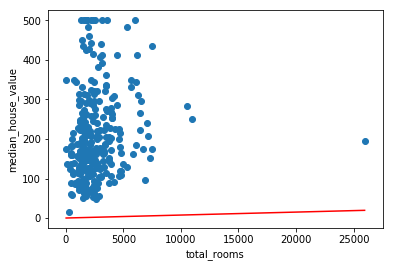

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


# Load dataset
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
print(california_housing_dataframe)

# Randomise data
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe
print(california_housing_dataframe)

# Examine data
california_housing_dataframe.describe()



# Predict median_house_value using total rooms as input
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]


# Define the label.
targets = california_housing_dataframe["median_house_value"]

# Configure the LinearRegressor
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)



def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


# Train the Model
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=1500
)

# Evaluate the model
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)


# Compare RMSE with (o/p max - o/p min)

min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)



# Investigate if our predictions match our targets
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

# First, we'll get a uniform random sample of the data so we can make a readable scatter plot.
sample = california_housing_dataframe.sample(n=300)



# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()